In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/home/nscl/diffusion_policy/dependencies/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Step 0: make images from every video

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import subprocess
from pathlib import Path
import re
from typing import Iterable, Optional, List

def _check_ffmpeg():
    try:
        subprocess.run(["ffmpeg", "-version"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except Exception as e:
        raise RuntimeError("ffmpeg가 설치되어 있지 않거나 PATH에 없습니다. `sudo apt-get install ffmpeg` 등으로 설치하세요.") from e

def find_episode_ids(base_dir: Path) -> List[int]:
    """base_dir/videos/#### 구조에서 ####(정수)를 모두 찾아 정렬해 반환."""
    vids = base_dir / "videos"
    if not vids.exists():
        raise FileNotFoundError(f"폴더가 없습니다: {vids}")
    eps = []
    for p in vids.iterdir():
        if p.is_dir() and re.fullmatch(r"\d{4}", p.name):
            eps.append(int(p.name))
    eps.sort()
    return eps

def extract_jpgs_for_episode(
    base_dir: Path,
    episode_id: int,
    camera: str = "orbbec",           # "orbbec"|"d405" 등
    output_subdir: Optional[str] = None,  # 기본: f"{camera}_jpg"
    q: int = 2,                       # -q:v (1~31, 낮을수록 고화질)
    start_number: int = 0,
    overwrite: bool = True,           # True면 기존 jpg 폴더 있더라도 덮어씀
    verbose: bool = True
) -> Path:
    """
    base_dir/videos/####/{camera}_video.mp4 -> base_dir/videos/####/{output_subdir}/%05d.jpg
    """
    ep_str = f"{episode_id:04d}"
    ep_dir = base_dir / "videos" / ep_str
    video_name = f"{camera}_video.mp4"
    video_path = ep_dir / video_name
    if not video_path.exists():
        raise FileNotFoundError(f"영상 없음: {video_path}")

    outdir = ep_dir / (output_subdir or f"{camera}_jpg")
    if outdir.exists():
        if overwrite:
            # 안전하게 비우기
            for f in outdir.glob("*.jpg"):
                try:
                    f.unlink()
                except Exception:
                    pass
        else:
            if verbose:
                print(f"[skip] {outdir} 이미 존재(overwrite=False)")
            return outdir
    else:
        outdir.mkdir(parents=True, exist_ok=True)

    # ffmpeg 실행
    out_pattern = outdir / "%05d.jpg"
    cmd = [
        "ffmpeg",
        "-y" if overwrite else "-n",
        "-hide_banner", "-loglevel", "error", "-stats",
        "-i", str(video_path),
        "-q:v", str(q),
        "-start_number", str(start_number),
        str(out_pattern)
    ]
    if verbose:
        print(f"[ffmpeg] ep {ep_str}: {' '.join(cmd)}")

    _check_ffmpeg()
    subprocess.run(cmd, check=True)

    # 결과 확인
    n_frames = len(list(outdir.glob("*.jpg")))
    if verbose:
        print(f"[ok] ep {ep_str}: {n_frames} frames -> {outdir}")
    return outdir

def extract_all(
    base_dir_str: str,
    episodes: Optional[Iterable[int]] = None,
    camera: str = "orbbec",
    output_subdir: Optional[str] = None,
    q: int = 2,
    start_number: int = 0,
    overwrite: bool = True
):
    base_dir = Path(base_dir_str).expanduser().resolve()
    if episodes is None:
        episodes = find_episode_ids(base_dir)
        if not episodes:
            raise RuntimeError(f"{base_dir}/videos/ 아래에서 에피소드 폴더(####)를 찾지 못했습니다.")
    for ep in episodes:
        extract_jpgs_for_episode(
            base_dir=base_dir,
            episode_id=int(ep),
            camera=camera,
            output_subdir=output_subdir,  # 기본: f"{camera}_jpg"
            q=q,
            start_number=start_number,
            overwrite=overwrite,
            verbose=True
        )

# -------------------- 사용 예시 --------------------
if __name__ == "__main__":
    data_set_root = "/home/nscl/diffusion_policy/data/please_please" 
    # 1) 전 에피소드 일괄 처리 (orbbec -> orbbec_jpg)
    extract_all(data_set_root, camera="orbbec")

    # 2) 특정 에피소드만 처리
    # extract_all("/home/nscl/diffusion_policy", episodes=[0, 3, 7], camera="orbbec")

    # 3) 출력 폴더명을 커스텀(예: "jpg")으로
    # extract_all("/home/nscl/diffusion_policy", output_subdir="jpg", camera="orbbec")


[ffmpeg] ep 0000: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0000/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0000/orbbec_jpg/%05d.jpg


frame=  596 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.86 bitrate=N/A speed=82.9x    


[ok] ep 0000: 596 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0000/orbbec_jpg
[ffmpeg] ep 0001: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0001/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0001/orbbec_jpg/%05d.jpg


frame=  634 fps=0.0 q=2.0 Lsize=N/A time=00:00:21.13 bitrate=N/A speed=80.9x    


[ok] ep 0001: 634 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0001/orbbec_jpg
[ffmpeg] ep 0002: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0002/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0002/orbbec_jpg/%05d.jpg


frame=  494 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.46 bitrate=N/A speed=73.5x    


[ok] ep 0002: 494 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0002/orbbec_jpg
[ffmpeg] ep 0003: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0003/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0003/orbbec_jpg/%05d.jpg


frame=  560 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.66 bitrate=N/A speed=79.9x    


[ok] ep 0003: 560 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0003/orbbec_jpg
[ffmpeg] ep 0004: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0004/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0004/orbbec_jpg/%05d.jpg


frame=  593 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.76 bitrate=N/A speed=80.9x    


[ok] ep 0004: 593 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0004/orbbec_jpg
[ffmpeg] ep 0005: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0005/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0005/orbbec_jpg/%05d.jpg


frame=  548 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.26 bitrate=N/A speed=  81x    


[ok] ep 0005: 548 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0005/orbbec_jpg
[ffmpeg] ep 0006: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0006/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0006/orbbec_jpg/%05d.jpg


frame=  569 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.96 bitrate=N/A speed=78.2x    


[ok] ep 0006: 569 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0006/orbbec_jpg
[ffmpeg] ep 0007: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0007/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0007/orbbec_jpg/%05d.jpg


frame=  611 fps=0.0 q=2.0 Lsize=N/A time=00:00:20.36 bitrate=N/A speed=82.9x    


[ok] ep 0007: 611 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0007/orbbec_jpg
[ffmpeg] ep 0008: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0008/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0008/orbbec_jpg/%05d.jpg


frame=  545 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.16 bitrate=N/A speed=80.4x    


[ok] ep 0008: 545 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0008/orbbec_jpg
[ffmpeg] ep 0009: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0009/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0009/orbbec_jpg/%05d.jpg


frame=  562 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.73 bitrate=N/A speed=83.4x    


[ok] ep 0009: 562 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0009/orbbec_jpg
[ffmpeg] ep 0010: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0010/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0010/orbbec_jpg/%05d.jpg


frame=  575 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.16 bitrate=N/A speed=78.8x    


[ok] ep 0010: 575 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0010/orbbec_jpg
[ffmpeg] ep 0011: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0011/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0011/orbbec_jpg/%05d.jpg


frame=  587 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.56 bitrate=N/A speed=81.3x    


[ok] ep 0011: 587 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0011/orbbec_jpg
[ffmpeg] ep 0012: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0012/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0012/orbbec_jpg/%05d.jpg


frame=  586 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.53 bitrate=N/A speed=83.6x    


[ok] ep 0012: 586 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0012/orbbec_jpg
[ffmpeg] ep 0013: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0013/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0013/orbbec_jpg/%05d.jpg


frame=  514 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.13 bitrate=N/A speed=81.9x    


[ok] ep 0013: 514 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0013/orbbec_jpg
[ffmpeg] ep 0014: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0014/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0014/orbbec_jpg/%05d.jpg


frame=  587 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.56 bitrate=N/A speed=  83x    


[ok] ep 0014: 587 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0014/orbbec_jpg
[ffmpeg] ep 0015: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0015/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0015/orbbec_jpg/%05d.jpg


frame=  557 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.56 bitrate=N/A speed=77.7x    


[ok] ep 0015: 557 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0015/orbbec_jpg
[ffmpeg] ep 0016: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0016/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0016/orbbec_jpg/%05d.jpg


frame=  532 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.73 bitrate=N/A speed=78.9x    


[ok] ep 0016: 532 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0016/orbbec_jpg
[ffmpeg] ep 0017: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0017/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0017/orbbec_jpg/%05d.jpg


frame=  539 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.96 bitrate=N/A speed=81.5x    


[ok] ep 0017: 539 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0017/orbbec_jpg
[ffmpeg] ep 0018: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0018/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0018/orbbec_jpg/%05d.jpg


frame=  515 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.16 bitrate=N/A speed=81.9x    


[ok] ep 0018: 515 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0018/orbbec_jpg
[ffmpeg] ep 0019: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0019/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0019/orbbec_jpg/%05d.jpg


frame=  601 fps=0.0 q=2.0 Lsize=N/A time=00:00:20.03 bitrate=N/A speed=82.7x    


[ok] ep 0019: 601 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0019/orbbec_jpg
[ffmpeg] ep 0020: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0020/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0020/orbbec_jpg/%05d.jpg


frame=  617 fps=0.0 q=2.0 Lsize=N/A time=00:00:20.56 bitrate=N/A speed=77.5x    


[ok] ep 0020: 617 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0020/orbbec_jpg
[ffmpeg] ep 0021: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0021/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0021/orbbec_jpg/%05d.jpg


frame=  547 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.23 bitrate=N/A speed=79.4x    


[ok] ep 0021: 547 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0021/orbbec_jpg
[ffmpeg] ep 0022: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0022/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0022/orbbec_jpg/%05d.jpg


frame=  692 fps=0.0 q=2.0 Lsize=N/A time=00:00:23.06 bitrate=N/A speed=83.6x    


[ok] ep 0022: 692 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0022/orbbec_jpg
[ffmpeg] ep 0023: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0023/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0023/orbbec_jpg/%05d.jpg


frame=  559 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.63 bitrate=N/A speed=83.3x    


[ok] ep 0023: 559 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0023/orbbec_jpg
[ffmpeg] ep 0024: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0024/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0024/orbbec_jpg/%05d.jpg


frame=  532 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.73 bitrate=N/A speed=  79x    


[ok] ep 0024: 532 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0024/orbbec_jpg
[ffmpeg] ep 0025: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0025/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0025/orbbec_jpg/%05d.jpg


frame=  493 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.43 bitrate=N/A speed=75.2x    


[ok] ep 0025: 493 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0025/orbbec_jpg
[ffmpeg] ep 0026: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0026/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0026/orbbec_jpg/%05d.jpg


frame=  520 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.33 bitrate=N/A speed=79.4x    


[ok] ep 0026: 520 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0026/orbbec_jpg
[ffmpeg] ep 0027: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0027/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0027/orbbec_jpg/%05d.jpg


frame=  500 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.66 bitrate=N/A speed=78.4x    


[ok] ep 0027: 500 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0027/orbbec_jpg
[ffmpeg] ep 0028: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0028/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0028/orbbec_jpg/%05d.jpg


frame=  461 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.36 bitrate=N/A speed=74.9x    


[ok] ep 0028: 461 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0028/orbbec_jpg
[ffmpeg] ep 0029: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0029/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0029/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=72.7x    


[ok] ep 0029: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0029/orbbec_jpg
[ffmpeg] ep 0030: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0030/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0030/orbbec_jpg/%05d.jpg


frame=  479 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.96 bitrate=N/A speed=78.4x    


[ok] ep 0030: 479 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0030/orbbec_jpg
[ffmpeg] ep 0031: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0031/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0031/orbbec_jpg/%05d.jpg


frame=  470 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.66 bitrate=N/A speed=78.3x    


[ok] ep 0031: 470 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0031/orbbec_jpg
[ffmpeg] ep 0032: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0032/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0032/orbbec_jpg/%05d.jpg


frame=  421 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.03 bitrate=N/A speed=  75x    


[ok] ep 0032: 421 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0032/orbbec_jpg
[ffmpeg] ep 0033: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0033/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0033/orbbec_jpg/%05d.jpg


frame=  455 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.16 bitrate=N/A speed=80.1x    


[ok] ep 0033: 455 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0033/orbbec_jpg
[ffmpeg] ep 0034: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0034/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0034/orbbec_jpg/%05d.jpg


frame=  530 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.66 bitrate=N/A speed=81.9x    


[ok] ep 0034: 530 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0034/orbbec_jpg
[ffmpeg] ep 0035: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0035/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0035/orbbec_jpg/%05d.jpg


frame=  511 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.03 bitrate=N/A speed=67.4x    


[ok] ep 0035: 511 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0035/orbbec_jpg
[ffmpeg] ep 0036: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0036/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0036/orbbec_jpg/%05d.jpg


frame=  489 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.30 bitrate=N/A speed=79.2x    


[ok] ep 0036: 489 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0036/orbbec_jpg
[ffmpeg] ep 0037: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0037/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0037/orbbec_jpg/%05d.jpg


frame=  445 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.83 bitrate=N/A speed=77.5x    


[ok] ep 0037: 445 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0037/orbbec_jpg
[ffmpeg] ep 0038: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0038/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0038/orbbec_jpg/%05d.jpg


frame=  454 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.13 bitrate=N/A speed=79.1x    


[ok] ep 0038: 454 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0038/orbbec_jpg
[ffmpeg] ep 0039: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0039/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0039/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=77.5x    


[ok] ep 0039: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0039/orbbec_jpg
[ffmpeg] ep 0040: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0040/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0040/orbbec_jpg/%05d.jpg


frame=  437 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.56 bitrate=N/A speed=77.3x    


[ok] ep 0040: 437 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0040/orbbec_jpg
[ffmpeg] ep 0041: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0041/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0041/orbbec_jpg/%05d.jpg


frame=  434 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.46 bitrate=N/A speed=76.3x    


[ok] ep 0041: 434 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0041/orbbec_jpg
[ffmpeg] ep 0042: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0042/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0042/orbbec_jpg/%05d.jpg


frame=  452 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.06 bitrate=N/A speed=80.4x    


[ok] ep 0042: 452 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0042/orbbec_jpg
[ffmpeg] ep 0043: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0043/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0043/orbbec_jpg/%05d.jpg


frame=  502 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.73 bitrate=N/A speed=79.1x    


[ok] ep 0043: 502 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0043/orbbec_jpg
[ffmpeg] ep 0044: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0044/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0044/orbbec_jpg/%05d.jpg


frame=  485 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.16 bitrate=N/A speed=75.3x    


[ok] ep 0044: 485 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0044/orbbec_jpg
[ffmpeg] ep 0045: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0045/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0045/orbbec_jpg/%05d.jpg


frame=  482 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.06 bitrate=N/A speed=73.3x    


[ok] ep 0045: 482 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0045/orbbec_jpg
[ffmpeg] ep 0046: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0046/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0046/orbbec_jpg/%05d.jpg


frame=  509 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.96 bitrate=N/A speed=75.9x    


[ok] ep 0046: 509 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0046/orbbec_jpg
[ffmpeg] ep 0047: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0047/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0047/orbbec_jpg/%05d.jpg


frame=  529 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.63 bitrate=N/A speed=78.6x    


[ok] ep 0047: 529 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0047/orbbec_jpg
[ffmpeg] ep 0048: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0048/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0048/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=76.7x    


[ok] ep 0048: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0048/orbbec_jpg
[ffmpeg] ep 0049: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0049/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0049/orbbec_jpg/%05d.jpg


frame=  502 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.73 bitrate=N/A speed=77.3x    


[ok] ep 0049: 502 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0049/orbbec_jpg
[ffmpeg] ep 0050: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0050/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0050/orbbec_jpg/%05d.jpg


frame=  493 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.43 bitrate=N/A speed=78.2x    


[ok] ep 0050: 493 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0050/orbbec_jpg
[ffmpeg] ep 0051: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0051/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0051/orbbec_jpg/%05d.jpg


frame=  446 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.86 bitrate=N/A speed=71.9x    


[ok] ep 0051: 446 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0051/orbbec_jpg
[ffmpeg] ep 0052: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0052/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0052/orbbec_jpg/%05d.jpg


frame=  442 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.73 bitrate=N/A speed=80.5x    


[ok] ep 0052: 442 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0052/orbbec_jpg
[ffmpeg] ep 0053: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0053/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0053/orbbec_jpg/%05d.jpg


frame=  518 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.26 bitrate=N/A speed=80.7x    


[ok] ep 0053: 518 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0053/orbbec_jpg
[ffmpeg] ep 0054: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0054/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0054/orbbec_jpg/%05d.jpg


frame=  440 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.66 bitrate=N/A speed=77.6x    


[ok] ep 0054: 440 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0054/orbbec_jpg
[ffmpeg] ep 0055: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0055/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0055/orbbec_jpg/%05d.jpg


frame=  436 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.53 bitrate=N/A speed=78.1x    


[ok] ep 0055: 436 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0055/orbbec_jpg
[ffmpeg] ep 0056: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0056/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0056/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=77.9x    


[ok] ep 0056: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0056/orbbec_jpg
[ffmpeg] ep 0057: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0057/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0057/orbbec_jpg/%05d.jpg


frame=  478 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.93 bitrate=N/A speed=79.9x    


[ok] ep 0057: 478 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0057/orbbec_jpg
[ffmpeg] ep 0058: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0058/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0058/orbbec_jpg/%05d.jpg


frame=  472 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.73 bitrate=N/A speed=79.7x    


[ok] ep 0058: 472 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0058/orbbec_jpg
[ffmpeg] ep 0059: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0059/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0059/orbbec_jpg/%05d.jpg


frame=  457 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.23 bitrate=N/A speed=78.4x    


[ok] ep 0059: 457 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0059/orbbec_jpg
[ffmpeg] ep 0060: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0060/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0060/orbbec_jpg/%05d.jpg


frame=  496 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.53 bitrate=N/A speed=79.6x    


[ok] ep 0060: 496 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0060/orbbec_jpg
[ffmpeg] ep 0061: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0061/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0061/orbbec_jpg/%05d.jpg


frame=  517 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.23 bitrate=N/A speed=78.1x    


[ok] ep 0061: 517 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0061/orbbec_jpg
[ffmpeg] ep 0062: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0062/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0062/orbbec_jpg/%05d.jpg


frame=  539 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.96 bitrate=N/A speed=74.3x    


[ok] ep 0062: 539 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0062/orbbec_jpg
[ffmpeg] ep 0063: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0063/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0063/orbbec_jpg/%05d.jpg


frame=  484 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.13 bitrate=N/A speed=78.2x    


[ok] ep 0063: 484 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0063/orbbec_jpg
[ffmpeg] ep 0064: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0064/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0064/orbbec_jpg/%05d.jpg


frame=  445 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.83 bitrate=N/A speed=77.9x    


[ok] ep 0064: 445 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0064/orbbec_jpg
[ffmpeg] ep 0065: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0065/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0065/orbbec_jpg/%05d.jpg


frame=  500 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.66 bitrate=N/A speed=76.8x    


[ok] ep 0065: 500 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0065/orbbec_jpg
[ffmpeg] ep 0066: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0066/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0066/orbbec_jpg/%05d.jpg


frame=  464 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.46 bitrate=N/A speed=78.1x    


[ok] ep 0066: 464 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0066/orbbec_jpg
[ffmpeg] ep 0067: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0067/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0067/orbbec_jpg/%05d.jpg


frame=  524 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.46 bitrate=N/A speed=75.4x    


[ok] ep 0067: 524 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0067/orbbec_jpg
[ffmpeg] ep 0068: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0068/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0068/orbbec_jpg/%05d.jpg


frame=  424 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.13 bitrate=N/A speed=75.2x    


[ok] ep 0068: 424 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0068/orbbec_jpg
[ffmpeg] ep 0069: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0069/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0069/orbbec_jpg/%05d.jpg


frame=  458 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.26 bitrate=N/A speed=77.7x    


[ok] ep 0069: 458 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0069/orbbec_jpg
[ffmpeg] ep 0070: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0070/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0070/orbbec_jpg/%05d.jpg


frame=  473 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.76 bitrate=N/A speed=77.9x    


[ok] ep 0070: 473 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0070/orbbec_jpg
[ffmpeg] ep 0071: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0071/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0071/orbbec_jpg/%05d.jpg


frame=  482 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.06 bitrate=N/A speed=79.8x    


[ok] ep 0071: 482 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0071/orbbec_jpg
[ffmpeg] ep 0072: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0072/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0072/orbbec_jpg/%05d.jpg


frame=  518 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.26 bitrate=N/A speed=78.7x    


[ok] ep 0072: 518 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0072/orbbec_jpg
[ffmpeg] ep 0073: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0073/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0073/orbbec_jpg/%05d.jpg


frame=  518 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.26 bitrate=N/A speed=73.9x    


[ok] ep 0073: 518 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0073/orbbec_jpg
[ffmpeg] ep 0074: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0074/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0074/orbbec_jpg/%05d.jpg


frame=  427 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.23 bitrate=N/A speed=77.9x    


[ok] ep 0074: 427 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0074/orbbec_jpg
[ffmpeg] ep 0075: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0075/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0075/orbbec_jpg/%05d.jpg


frame=  470 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.66 bitrate=N/A speed=78.5x    


[ok] ep 0075: 470 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0075/orbbec_jpg
[ffmpeg] ep 0076: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0076/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0076/orbbec_jpg/%05d.jpg


frame=  578 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.26 bitrate=N/A speed=83.1x    


[ok] ep 0076: 578 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0076/orbbec_jpg
[ffmpeg] ep 0077: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0077/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0077/orbbec_jpg/%05d.jpg


frame=  463 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.43 bitrate=N/A speed=76.2x    


[ok] ep 0077: 463 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0077/orbbec_jpg
[ffmpeg] ep 0078: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0078/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0078/orbbec_jpg/%05d.jpg


frame=  521 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.36 bitrate=N/A speed=79.2x    


[ok] ep 0078: 521 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0078/orbbec_jpg
[ffmpeg] ep 0079: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0079/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0079/orbbec_jpg/%05d.jpg


frame=  463 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.43 bitrate=N/A speed=72.2x    


[ok] ep 0079: 463 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0079/orbbec_jpg
[ffmpeg] ep 0080: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0080/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0080/orbbec_jpg/%05d.jpg


frame=  538 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.93 bitrate=N/A speed=79.4x    


[ok] ep 0080: 538 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0080/orbbec_jpg
[ffmpeg] ep 0081: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0081/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0081/orbbec_jpg/%05d.jpg


frame=  467 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.56 bitrate=N/A speed=76.1x    


[ok] ep 0081: 467 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0081/orbbec_jpg
[ffmpeg] ep 0082: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0082/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0082/orbbec_jpg/%05d.jpg


frame=  548 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.26 bitrate=N/A speed=80.4x    


[ok] ep 0082: 548 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0082/orbbec_jpg
[ffmpeg] ep 0083: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0083/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0083/orbbec_jpg/%05d.jpg


frame=  590 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.66 bitrate=N/A speed=81.5x    


[ok] ep 0083: 590 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0083/orbbec_jpg
[ffmpeg] ep 0084: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0084/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0084/orbbec_jpg/%05d.jpg


frame=  502 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.73 bitrate=N/A speed=  75x    


[ok] ep 0084: 502 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0084/orbbec_jpg
[ffmpeg] ep 0085: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0085/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0085/orbbec_jpg/%05d.jpg


frame=  533 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.76 bitrate=N/A speed=78.2x    


[ok] ep 0085: 533 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0085/orbbec_jpg
[ffmpeg] ep 0086: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0086/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0086/orbbec_jpg/%05d.jpg


frame=  518 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.26 bitrate=N/A speed=75.7x    


[ok] ep 0086: 518 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0086/orbbec_jpg
[ffmpeg] ep 0087: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0087/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0087/orbbec_jpg/%05d.jpg


frame=  461 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.36 bitrate=N/A speed=71.4x    


[ok] ep 0087: 461 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0087/orbbec_jpg
[ffmpeg] ep 0088: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0088/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0088/orbbec_jpg/%05d.jpg


frame=  463 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.43 bitrate=N/A speed=75.9x    


[ok] ep 0088: 463 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0088/orbbec_jpg
[ffmpeg] ep 0089: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0089/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0089/orbbec_jpg/%05d.jpg


frame=  517 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.23 bitrate=N/A speed=  74x    


[ok] ep 0089: 517 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0089/orbbec_jpg
[ffmpeg] ep 0090: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0090/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0090/orbbec_jpg/%05d.jpg


frame=  545 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.16 bitrate=N/A speed=73.7x    


[ok] ep 0090: 545 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0090/orbbec_jpg
[ffmpeg] ep 0091: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0091/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0091/orbbec_jpg/%05d.jpg


frame=  547 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.23 bitrate=N/A speed=77.9x    


[ok] ep 0091: 547 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0091/orbbec_jpg
[ffmpeg] ep 0092: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0092/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0092/orbbec_jpg/%05d.jpg


frame=  479 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.96 bitrate=N/A speed=76.4x    


[ok] ep 0092: 479 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0092/orbbec_jpg
[ffmpeg] ep 0093: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0093/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0093/orbbec_jpg/%05d.jpg


frame=  452 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.06 bitrate=N/A speed=76.4x    


[ok] ep 0093: 452 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0093/orbbec_jpg
[ffmpeg] ep 0094: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0094/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0094/orbbec_jpg/%05d.jpg


frame=  584 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.46 bitrate=N/A speed=77.5x    


[ok] ep 0094: 584 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0094/orbbec_jpg
[ffmpeg] ep 0095: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0095/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0095/orbbec_jpg/%05d.jpg


frame=  487 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.23 bitrate=N/A speed=71.6x    


[ok] ep 0095: 487 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0095/orbbec_jpg
[ffmpeg] ep 0096: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0096/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0096/orbbec_jpg/%05d.jpg


frame=  499 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.63 bitrate=N/A speed=77.5x    


[ok] ep 0096: 499 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0096/orbbec_jpg
[ffmpeg] ep 0097: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0097/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0097/orbbec_jpg/%05d.jpg


frame=  532 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.73 bitrate=N/A speed=77.4x    


[ok] ep 0097: 532 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0097/orbbec_jpg
[ffmpeg] ep 0098: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0098/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0098/orbbec_jpg/%05d.jpg


frame=  472 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.73 bitrate=N/A speed=77.8x    


[ok] ep 0098: 472 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0098/orbbec_jpg
[ffmpeg] ep 0099: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0099/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0099/orbbec_jpg/%05d.jpg


frame=  527 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.56 bitrate=N/A speed=77.9x    


[ok] ep 0099: 527 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0099/orbbec_jpg
[ffmpeg] ep 0100: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0100/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0100/orbbec_jpg/%05d.jpg


frame=  539 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.96 bitrate=N/A speed=76.5x    


[ok] ep 0100: 539 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0100/orbbec_jpg
[ffmpeg] ep 0101: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0101/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0101/orbbec_jpg/%05d.jpg


frame=  505 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.83 bitrate=N/A speed=74.9x    


[ok] ep 0101: 505 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0101/orbbec_jpg
[ffmpeg] ep 0102: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0102/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0102/orbbec_jpg/%05d.jpg


frame=  469 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.63 bitrate=N/A speed=70.4x    


[ok] ep 0102: 469 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0102/orbbec_jpg
[ffmpeg] ep 0103: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0103/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0103/orbbec_jpg/%05d.jpg


frame=  439 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.63 bitrate=N/A speed=  75x    


[ok] ep 0103: 439 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0103/orbbec_jpg
[ffmpeg] ep 0104: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0104/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0104/orbbec_jpg/%05d.jpg


frame=  448 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.93 bitrate=N/A speed=75.4x    


[ok] ep 0104: 448 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0104/orbbec_jpg
[ffmpeg] ep 0105: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0105/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0105/orbbec_jpg/%05d.jpg


frame=  511 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.03 bitrate=N/A speed=74.4x    


[ok] ep 0105: 511 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0105/orbbec_jpg
[ffmpeg] ep 0106: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0106/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0106/orbbec_jpg/%05d.jpg


frame=  535 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.83 bitrate=N/A speed=71.3x    


[ok] ep 0106: 535 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0106/orbbec_jpg
[ffmpeg] ep 0107: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0107/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0107/orbbec_jpg/%05d.jpg


frame=  457 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.23 bitrate=N/A speed=  76x    


[ok] ep 0107: 457 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0107/orbbec_jpg
[ffmpeg] ep 0108: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0108/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0108/orbbec_jpg/%05d.jpg


frame=  503 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.76 bitrate=N/A speed=76.8x    


[ok] ep 0108: 503 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0108/orbbec_jpg
[ffmpeg] ep 0109: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0109/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0109/orbbec_jpg/%05d.jpg


frame=  494 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.46 bitrate=N/A speed=  75x    


[ok] ep 0109: 494 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0109/orbbec_jpg
[ffmpeg] ep 0110: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0110/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0110/orbbec_jpg/%05d.jpg


frame=  454 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.13 bitrate=N/A speed=75.3x    


[ok] ep 0110: 454 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0110/orbbec_jpg
[ffmpeg] ep 0111: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0111/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0111/orbbec_jpg/%05d.jpg


frame=  496 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.53 bitrate=N/A speed=76.8x    


[ok] ep 0111: 496 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0111/orbbec_jpg
[ffmpeg] ep 0112: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0112/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0112/orbbec_jpg/%05d.jpg


frame=  557 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.56 bitrate=N/A speed=73.8x    


[ok] ep 0112: 557 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0112/orbbec_jpg
[ffmpeg] ep 0113: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0113/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0113/orbbec_jpg/%05d.jpg


frame=  493 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.43 bitrate=N/A speed=78.5x    


[ok] ep 0113: 493 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0113/orbbec_jpg
[ffmpeg] ep 0114: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0114/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0114/orbbec_jpg/%05d.jpg


frame=  505 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.83 bitrate=N/A speed=75.4x    


[ok] ep 0114: 505 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0114/orbbec_jpg
[ffmpeg] ep 0115: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0115/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0115/orbbec_jpg/%05d.jpg


frame=  536 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.86 bitrate=N/A speed=70.5x    


[ok] ep 0115: 536 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0115/orbbec_jpg
[ffmpeg] ep 0116: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0116/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0116/orbbec_jpg/%05d.jpg


frame=  470 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.66 bitrate=N/A speed=78.3x    


[ok] ep 0116: 470 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0116/orbbec_jpg
[ffmpeg] ep 0117: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0117/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0117/orbbec_jpg/%05d.jpg


frame=  461 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.36 bitrate=N/A speed=75.6x    


[ok] ep 0117: 461 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0117/orbbec_jpg
[ffmpeg] ep 0118: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0118/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0118/orbbec_jpg/%05d.jpg


frame=  454 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.13 bitrate=N/A speed=72.6x    


[ok] ep 0118: 454 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0118/orbbec_jpg
[ffmpeg] ep 0119: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0119/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0119/orbbec_jpg/%05d.jpg


frame=  536 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.86 bitrate=N/A speed=77.7x    


[ok] ep 0119: 536 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0119/orbbec_jpg
[ffmpeg] ep 0120: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0120/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0120/orbbec_jpg/%05d.jpg


frame=  484 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.13 bitrate=N/A speed=72.6x    


[ok] ep 0120: 484 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0120/orbbec_jpg
[ffmpeg] ep 0121: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0121/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0121/orbbec_jpg/%05d.jpg


frame=  463 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.43 bitrate=N/A speed=76.7x    


[ok] ep 0121: 463 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0121/orbbec_jpg
[ffmpeg] ep 0122: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0122/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0122/orbbec_jpg/%05d.jpg


frame=  466 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.53 bitrate=N/A speed=75.4x    


[ok] ep 0122: 466 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0122/orbbec_jpg
[ffmpeg] ep 0123: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0123/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0123/orbbec_jpg/%05d.jpg


frame=  415 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.83 bitrate=N/A speed=76.9x    


[ok] ep 0123: 415 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0123/orbbec_jpg
[ffmpeg] ep 0124: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0124/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0124/orbbec_jpg/%05d.jpg


frame=  461 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.36 bitrate=N/A speed=79.8x    


[ok] ep 0124: 461 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0124/orbbec_jpg
[ffmpeg] ep 0125: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0125/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0125/orbbec_jpg/%05d.jpg


frame=  497 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.56 bitrate=N/A speed=77.5x    


[ok] ep 0125: 497 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0125/orbbec_jpg
[ffmpeg] ep 0126: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0126/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0126/orbbec_jpg/%05d.jpg


frame=  488 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.26 bitrate=N/A speed=70.6x    


[ok] ep 0126: 488 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0126/orbbec_jpg
[ffmpeg] ep 0127: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0127/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0127/orbbec_jpg/%05d.jpg


frame=  485 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.16 bitrate=N/A speed=80.9x    


[ok] ep 0127: 485 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0127/orbbec_jpg
[ffmpeg] ep 0128: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0128/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0128/orbbec_jpg/%05d.jpg


frame=  464 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.46 bitrate=N/A speed=76.5x    


[ok] ep 0128: 464 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0128/orbbec_jpg
[ffmpeg] ep 0129: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0129/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0129/orbbec_jpg/%05d.jpg


frame=  475 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.83 bitrate=N/A speed=77.5x    


[ok] ep 0129: 475 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0129/orbbec_jpg
[ffmpeg] ep 0130: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0130/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0130/orbbec_jpg/%05d.jpg


frame=  487 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.23 bitrate=N/A speed=76.4x    


[ok] ep 0130: 487 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0130/orbbec_jpg
[ffmpeg] ep 0131: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0131/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0131/orbbec_jpg/%05d.jpg


frame=  520 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.33 bitrate=N/A speed=78.7x    


[ok] ep 0131: 520 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0131/orbbec_jpg
[ffmpeg] ep 0132: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0132/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0132/orbbec_jpg/%05d.jpg


frame=  436 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.53 bitrate=N/A speed=64.5x    


[ok] ep 0132: 436 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0132/orbbec_jpg
[ffmpeg] ep 0133: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0133/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0133/orbbec_jpg/%05d.jpg


frame=  439 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.63 bitrate=N/A speed=76.4x    


[ok] ep 0133: 439 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0133/orbbec_jpg
[ffmpeg] ep 0134: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0134/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0134/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=75.7x    


[ok] ep 0134: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0134/orbbec_jpg
[ffmpeg] ep 0135: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0135/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0135/orbbec_jpg/%05d.jpg


frame=  539 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.96 bitrate=N/A speed=76.2x    


[ok] ep 0135: 539 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0135/orbbec_jpg
[ffmpeg] ep 0136: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0136/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0136/orbbec_jpg/%05d.jpg


frame=  499 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.63 bitrate=N/A speed=73.9x    


[ok] ep 0136: 499 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0136/orbbec_jpg
[ffmpeg] ep 0137: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0137/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0137/orbbec_jpg/%05d.jpg


frame=  466 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.53 bitrate=N/A speed=76.1x    


[ok] ep 0137: 466 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0137/orbbec_jpg
[ffmpeg] ep 0138: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0138/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0138/orbbec_jpg/%05d.jpg


frame=  514 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.13 bitrate=N/A speed=72.6x    


[ok] ep 0138: 514 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0138/orbbec_jpg
[ffmpeg] ep 0139: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0139/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0139/orbbec_jpg/%05d.jpg


frame=  523 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.43 bitrate=N/A speed=75.8x    


[ok] ep 0139: 523 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0139/orbbec_jpg
[ffmpeg] ep 0140: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0140/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0140/orbbec_jpg/%05d.jpg


frame=  427 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.23 bitrate=N/A speed=77.8x    


[ok] ep 0140: 427 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0140/orbbec_jpg
[ffmpeg] ep 0141: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0141/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0141/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=78.6x    


[ok] ep 0141: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0141/orbbec_jpg
[ffmpeg] ep 0142: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0142/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0142/orbbec_jpg/%05d.jpg


frame=  512 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.06 bitrate=N/A speed=76.2x    


[ok] ep 0142: 512 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0142/orbbec_jpg
[ffmpeg] ep 0143: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0143/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0143/orbbec_jpg/%05d.jpg


frame=  515 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.16 bitrate=N/A speed=70.9x    


[ok] ep 0143: 515 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0143/orbbec_jpg
[ffmpeg] ep 0144: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0144/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0144/orbbec_jpg/%05d.jpg


frame=  404 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.46 bitrate=N/A speed=74.2x    


[ok] ep 0144: 404 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0144/orbbec_jpg
[ffmpeg] ep 0145: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0145/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0145/orbbec_jpg/%05d.jpg


frame=  472 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.73 bitrate=N/A speed=78.8x    


[ok] ep 0145: 472 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0145/orbbec_jpg
[ffmpeg] ep 0146: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0146/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0146/orbbec_jpg/%05d.jpg


frame=  458 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.26 bitrate=N/A speed=78.3x    


[ok] ep 0146: 458 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0146/orbbec_jpg
[ffmpeg] ep 0147: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0147/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0147/orbbec_jpg/%05d.jpg


frame=  635 fps=0.0 q=2.0 Lsize=N/A time=00:00:21.16 bitrate=N/A speed=81.7x    


[ok] ep 0147: 635 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0147/orbbec_jpg
[ffmpeg] ep 0148: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0148/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0148/orbbec_jpg/%05d.jpg


frame=  436 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.53 bitrate=N/A speed=76.3x    


[ok] ep 0148: 436 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0148/orbbec_jpg
[ffmpeg] ep 0149: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0149/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0149/orbbec_jpg/%05d.jpg


frame=  454 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.13 bitrate=N/A speed=72.5x    


[ok] ep 0149: 454 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0149/orbbec_jpg
[ffmpeg] ep 0150: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0150/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0150/orbbec_jpg/%05d.jpg


frame=  451 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.03 bitrate=N/A speed=78.9x    


[ok] ep 0150: 451 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0150/orbbec_jpg
[ffmpeg] ep 0151: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0151/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0151/orbbec_jpg/%05d.jpg


frame=  544 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.13 bitrate=N/A speed=  79x    


[ok] ep 0151: 544 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0151/orbbec_jpg
[ffmpeg] ep 0152: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0152/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0152/orbbec_jpg/%05d.jpg


frame=  454 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.13 bitrate=N/A speed=75.6x    


[ok] ep 0152: 454 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0152/orbbec_jpg
[ffmpeg] ep 0153: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0153/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0153/orbbec_jpg/%05d.jpg


frame=  493 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.43 bitrate=N/A speed=79.8x    


[ok] ep 0153: 493 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0153/orbbec_jpg
[ffmpeg] ep 0154: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0154/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0154/orbbec_jpg/%05d.jpg


frame=  448 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.93 bitrate=N/A speed=78.2x    


[ok] ep 0154: 448 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0154/orbbec_jpg
[ffmpeg] ep 0155: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0155/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0155/orbbec_jpg/%05d.jpg


frame=  415 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.83 bitrate=N/A speed=73.8x    


[ok] ep 0155: 415 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0155/orbbec_jpg
[ffmpeg] ep 0156: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0156/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0156/orbbec_jpg/%05d.jpg


frame=  499 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.63 bitrate=N/A speed=81.7x    


[ok] ep 0156: 499 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0156/orbbec_jpg
[ffmpeg] ep 0157: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0157/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0157/orbbec_jpg/%05d.jpg


frame=  454 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.13 bitrate=N/A speed=80.4x    


[ok] ep 0157: 454 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0157/orbbec_jpg
[ffmpeg] ep 0158: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0158/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0158/orbbec_jpg/%05d.jpg


frame=  487 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.23 bitrate=N/A speed=79.2x    


[ok] ep 0158: 487 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0158/orbbec_jpg
[ffmpeg] ep 0159: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0159/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0159/orbbec_jpg/%05d.jpg


frame=  469 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.63 bitrate=N/A speed=77.6x    


[ok] ep 0159: 469 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0159/orbbec_jpg
[ffmpeg] ep 0160: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0160/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0160/orbbec_jpg/%05d.jpg


frame=  478 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.93 bitrate=N/A speed=74.3x    


[ok] ep 0160: 478 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0160/orbbec_jpg
[ffmpeg] ep 0161: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0161/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0161/orbbec_jpg/%05d.jpg


frame=  439 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.63 bitrate=N/A speed=68.6x    


[ok] ep 0161: 439 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0161/orbbec_jpg
[ffmpeg] ep 0162: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0162/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0162/orbbec_jpg/%05d.jpg


frame=  418 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.93 bitrate=N/A speed=76.8x    


[ok] ep 0162: 418 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0162/orbbec_jpg
[ffmpeg] ep 0163: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0163/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0163/orbbec_jpg/%05d.jpg


frame=  424 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.13 bitrate=N/A speed=77.5x    


[ok] ep 0163: 424 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0163/orbbec_jpg
[ffmpeg] ep 0164: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0164/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0164/orbbec_jpg/%05d.jpg


frame=  451 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.03 bitrate=N/A speed=78.5x    


[ok] ep 0164: 451 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0164/orbbec_jpg
[ffmpeg] ep 0165: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0165/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0165/orbbec_jpg/%05d.jpg


frame=  421 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.03 bitrate=N/A speed=68.7x    


[ok] ep 0165: 421 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0165/orbbec_jpg
[ffmpeg] ep 0166: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0166/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0166/orbbec_jpg/%05d.jpg


frame=  479 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.96 bitrate=N/A speed=76.8x    


[ok] ep 0166: 479 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0166/orbbec_jpg
[ffmpeg] ep 0167: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0167/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0167/orbbec_jpg/%05d.jpg


frame=  509 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.96 bitrate=N/A speed=79.7x    


[ok] ep 0167: 509 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0167/orbbec_jpg
[ffmpeg] ep 0168: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0168/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0168/orbbec_jpg/%05d.jpg


frame=  485 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.16 bitrate=N/A speed=79.4x    


[ok] ep 0168: 485 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0168/orbbec_jpg
[ffmpeg] ep 0169: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0169/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0169/orbbec_jpg/%05d.jpg


frame=  421 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.03 bitrate=N/A speed=75.1x    


[ok] ep 0169: 421 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0169/orbbec_jpg
[ffmpeg] ep 0170: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0170/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0170/orbbec_jpg/%05d.jpg


frame=  418 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.93 bitrate=N/A speed=78.1x    


[ok] ep 0170: 418 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0170/orbbec_jpg
[ffmpeg] ep 0171: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0171/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0171/orbbec_jpg/%05d.jpg


frame=  400 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.33 bitrate=N/A speed=73.3x    


[ok] ep 0171: 400 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0171/orbbec_jpg
[ffmpeg] ep 0172: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0172/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0172/orbbec_jpg/%05d.jpg


frame=  431 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.36 bitrate=N/A speed=79.3x    


[ok] ep 0172: 431 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0172/orbbec_jpg
[ffmpeg] ep 0173: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0173/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0173/orbbec_jpg/%05d.jpg


frame=  463 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.43 bitrate=N/A speed=80.9x    


[ok] ep 0173: 463 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0173/orbbec_jpg
[ffmpeg] ep 0174: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0174/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0174/orbbec_jpg/%05d.jpg


frame=  418 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.93 bitrate=N/A speed=76.4x    


[ok] ep 0174: 418 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0174/orbbec_jpg
[ffmpeg] ep 0175: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0175/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0175/orbbec_jpg/%05d.jpg


frame=  439 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.63 bitrate=N/A speed=  75x    


[ok] ep 0175: 439 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0175/orbbec_jpg
[ffmpeg] ep 0176: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0176/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0176/orbbec_jpg/%05d.jpg


frame=  424 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.13 bitrate=N/A speed=76.1x    


[ok] ep 0176: 424 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0176/orbbec_jpg
[ffmpeg] ep 0177: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0177/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0177/orbbec_jpg/%05d.jpg


frame=  445 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.83 bitrate=N/A speed=77.4x    


[ok] ep 0177: 445 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0177/orbbec_jpg
[ffmpeg] ep 0178: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0178/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0178/orbbec_jpg/%05d.jpg


frame=  554 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.46 bitrate=N/A speed=81.2x    


[ok] ep 0178: 554 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0178/orbbec_jpg
[ffmpeg] ep 0179: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0179/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0179/orbbec_jpg/%05d.jpg


frame=  439 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.63 bitrate=N/A speed=  74x    


[ok] ep 0179: 439 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0179/orbbec_jpg
[ffmpeg] ep 0180: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0180/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0180/orbbec_jpg/%05d.jpg


frame=  451 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.03 bitrate=N/A speed=67.9x    


[ok] ep 0180: 451 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0180/orbbec_jpg
[ffmpeg] ep 0181: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0181/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0181/orbbec_jpg/%05d.jpg


frame=  476 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.86 bitrate=N/A speed=67.7x    


[ok] ep 0181: 476 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0181/orbbec_jpg
[ffmpeg] ep 0182: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0182/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0182/orbbec_jpg/%05d.jpg


frame=  406 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.53 bitrate=N/A speed=70.6x    


[ok] ep 0182: 406 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0182/orbbec_jpg
[ffmpeg] ep 0183: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0183/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0183/orbbec_jpg/%05d.jpg


frame=  451 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.03 bitrate=N/A speed=78.9x    


[ok] ep 0183: 451 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0183/orbbec_jpg
[ffmpeg] ep 0184: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0184/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0184/orbbec_jpg/%05d.jpg


frame=  502 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.73 bitrate=N/A speed=  78x    


[ok] ep 0184: 502 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0184/orbbec_jpg
[ffmpeg] ep 0185: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0185/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0185/orbbec_jpg/%05d.jpg


frame=  481 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.03 bitrate=N/A speed=76.7x    


[ok] ep 0185: 481 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0185/orbbec_jpg
[ffmpeg] ep 0186: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0186/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0186/orbbec_jpg/%05d.jpg


frame=  436 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.53 bitrate=N/A speed=76.8x    


[ok] ep 0186: 436 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0186/orbbec_jpg
[ffmpeg] ep 0187: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0187/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0187/orbbec_jpg/%05d.jpg


frame=  403 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.43 bitrate=N/A speed=74.4x    


[ok] ep 0187: 403 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0187/orbbec_jpg
[ffmpeg] ep 0188: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0188/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0188/orbbec_jpg/%05d.jpg


frame=  475 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.83 bitrate=N/A speed=70.8x    


[ok] ep 0188: 475 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0188/orbbec_jpg
[ffmpeg] ep 0189: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0189/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0189/orbbec_jpg/%05d.jpg


frame=  457 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.23 bitrate=N/A speed=71.3x    


[ok] ep 0189: 457 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0189/orbbec_jpg
[ffmpeg] ep 0190: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0190/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0190/orbbec_jpg/%05d.jpg


frame=  520 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.33 bitrate=N/A speed=73.8x    


[ok] ep 0190: 520 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0190/orbbec_jpg
[ffmpeg] ep 0191: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0191/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0191/orbbec_jpg/%05d.jpg


frame=  457 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.23 bitrate=N/A speed=73.1x    


[ok] ep 0191: 457 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0191/orbbec_jpg
[ffmpeg] ep 0192: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0192/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0192/orbbec_jpg/%05d.jpg


frame=  526 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.53 bitrate=N/A speed=73.9x    


[ok] ep 0192: 526 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0192/orbbec_jpg
[ffmpeg] ep 0193: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0193/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0193/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=71.8x    


[ok] ep 0193: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0193/orbbec_jpg
[ffmpeg] ep 0194: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0194/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0194/orbbec_jpg/%05d.jpg


frame=  454 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.13 bitrate=N/A speed=77.6x    


[ok] ep 0194: 454 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0194/orbbec_jpg
[ffmpeg] ep 0195: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0195/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0195/orbbec_jpg/%05d.jpg


frame=  448 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.93 bitrate=N/A speed=76.8x    


[ok] ep 0195: 448 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0195/orbbec_jpg
[ffmpeg] ep 0196: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0196/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0196/orbbec_jpg/%05d.jpg


frame=  494 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.46 bitrate=N/A speed=78.6x    


[ok] ep 0196: 494 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0196/orbbec_jpg
[ffmpeg] ep 0197: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0197/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0197/orbbec_jpg/%05d.jpg


frame=  410 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.66 bitrate=N/A speed=75.8x    


[ok] ep 0197: 410 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0197/orbbec_jpg
[ffmpeg] ep 0198: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0198/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0198/orbbec_jpg/%05d.jpg


frame=  524 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.46 bitrate=N/A speed=78.6x    


[ok] ep 0198: 524 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0198/orbbec_jpg
[ffmpeg] ep 0199: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0199/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0199/orbbec_jpg/%05d.jpg


frame=  574 fps=0.0 q=2.0 Lsize=N/A time=00:00:19.13 bitrate=N/A speed=  78x    


[ok] ep 0199: 574 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0199/orbbec_jpg
[ffmpeg] ep 0200: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0200/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0200/orbbec_jpg/%05d.jpg


frame=  623 fps=0.0 q=2.0 Lsize=N/A time=00:00:20.76 bitrate=N/A speed=76.1x    


[ok] ep 0200: 623 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0200/orbbec_jpg
[ffmpeg] ep 0201: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0201/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0201/orbbec_jpg/%05d.jpg


frame=  430 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.33 bitrate=N/A speed=  78x    


[ok] ep 0201: 430 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0201/orbbec_jpg
[ffmpeg] ep 0202: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0202/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0202/orbbec_jpg/%05d.jpg


frame=  463 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.43 bitrate=N/A speed=77.3x    


[ok] ep 0202: 463 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0202/orbbec_jpg
[ffmpeg] ep 0203: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0203/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0203/orbbec_jpg/%05d.jpg


frame=  430 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.33 bitrate=N/A speed=78.1x    


[ok] ep 0203: 430 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0203/orbbec_jpg
[ffmpeg] ep 0204: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0204/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0204/orbbec_jpg/%05d.jpg


frame=  422 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.06 bitrate=N/A speed=75.5x    


[ok] ep 0204: 422 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0204/orbbec_jpg
[ffmpeg] ep 0205: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0205/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0205/orbbec_jpg/%05d.jpg


frame=  512 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.06 bitrate=N/A speed=78.6x    


[ok] ep 0205: 512 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0205/orbbec_jpg
[ffmpeg] ep 0206: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0206/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0206/orbbec_jpg/%05d.jpg


frame=  491 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.36 bitrate=N/A speed=  67x    


[ok] ep 0206: 491 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0206/orbbec_jpg
[ffmpeg] ep 0207: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0207/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0207/orbbec_jpg/%05d.jpg


frame=  395 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.16 bitrate=N/A speed=  76x    


[ok] ep 0207: 395 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0207/orbbec_jpg
[ffmpeg] ep 0208: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0208/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0208/orbbec_jpg/%05d.jpg


frame=  424 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.13 bitrate=N/A speed=76.7x    


[ok] ep 0208: 424 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0208/orbbec_jpg
[ffmpeg] ep 0209: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0209/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0209/orbbec_jpg/%05d.jpg


frame=  457 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.23 bitrate=N/A speed=78.3x    


[ok] ep 0209: 457 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0209/orbbec_jpg
[ffmpeg] ep 0210: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0210/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0210/orbbec_jpg/%05d.jpg


frame=  568 fps=0.0 q=2.0 Lsize=N/A time=00:00:18.93 bitrate=N/A speed=78.7x    


[ok] ep 0210: 568 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0210/orbbec_jpg
[ffmpeg] ep 0211: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0211/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0211/orbbec_jpg/%05d.jpg


frame=  533 fps=0.0 q=2.0 Lsize=N/A time=00:00:17.76 bitrate=N/A speed=76.1x    


[ok] ep 0211: 533 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0211/orbbec_jpg
[ffmpeg] ep 0212: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0212/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0212/orbbec_jpg/%05d.jpg


frame=  460 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.33 bitrate=N/A speed=78.6x    


[ok] ep 0212: 460 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0212/orbbec_jpg
[ffmpeg] ep 0213: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0213/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0213/orbbec_jpg/%05d.jpg


frame=  505 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.83 bitrate=N/A speed=77.9x    


[ok] ep 0213: 505 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0213/orbbec_jpg
[ffmpeg] ep 0214: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0214/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0214/orbbec_jpg/%05d.jpg


frame=  508 fps=0.0 q=2.0 Lsize=N/A time=00:00:16.93 bitrate=N/A speed=75.9x    


[ok] ep 0214: 508 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0214/orbbec_jpg
[ffmpeg] ep 0215: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0215/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0215/orbbec_jpg/%05d.jpg


frame=  418 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.93 bitrate=N/A speed=  77x    


[ok] ep 0215: 418 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0215/orbbec_jpg
[ffmpeg] ep 0216: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0216/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0216/orbbec_jpg/%05d.jpg


frame=  430 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.33 bitrate=N/A speed=  77x    


[ok] ep 0216: 430 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0216/orbbec_jpg
[ffmpeg] ep 0217: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0217/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0217/orbbec_jpg/%05d.jpg


frame=  421 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.03 bitrate=N/A speed=77.9x    


[ok] ep 0217: 421 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0217/orbbec_jpg
[ffmpeg] ep 0218: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0218/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0218/orbbec_jpg/%05d.jpg


frame=  352 fps=0.0 q=2.0 Lsize=N/A time=00:00:11.73 bitrate=N/A speed=75.4x    


[ok] ep 0218: 352 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0218/orbbec_jpg
[ffmpeg] ep 0219: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0219/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0219/orbbec_jpg/%05d.jpg


frame=  434 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.46 bitrate=N/A speed=71.3x    


[ok] ep 0219: 434 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0219/orbbec_jpg
[ffmpeg] ep 0220: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0220/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0220/orbbec_jpg/%05d.jpg


frame=  421 fps=0.0 q=2.0 Lsize=N/A time=00:00:14.03 bitrate=N/A speed=73.8x    


[ok] ep 0220: 421 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0220/orbbec_jpg
[ffmpeg] ep 0221: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0221/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0221/orbbec_jpg/%05d.jpg


frame=  418 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.93 bitrate=N/A speed=75.5x    


[ok] ep 0221: 418 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0221/orbbec_jpg
[ffmpeg] ep 0222: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0222/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0222/orbbec_jpg/%05d.jpg


frame=  397 fps=0.0 q=2.0 Lsize=N/A time=00:00:13.23 bitrate=N/A speed=73.5x    


[ok] ep 0222: 397 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0222/orbbec_jpg
[ffmpeg] ep 0223: ffmpeg -y -hide_banner -loglevel error -stats -i /home/nscl/diffusion_policy/data/please_please/videos/0223/orbbec_video.mp4 -q:v 2 -start_number 0 /home/nscl/diffusion_policy/data/please_please/videos/0223/orbbec_jpg/%05d.jpg
[ok] ep 0223: 476 frames -> /home/nscl/diffusion_policy/data/please_please/videos/0223/orbbec_jpg


frame=  476 fps=0.0 q=2.0 Lsize=N/A time=00:00:15.86 bitrate=N/A speed=79.2x    


#### Select an example video

비디오는 `<frame_index>.jpg`와 같은 파일 이름을 가진 JPEG 프레임 목록으로 저장되어 있다고 가정합니다.

사용자 지정 비디오의 경우 ffmpeg(https://ffmpeg.org/)를 사용하여 다음과 같이 JPEG 프레임을 추출할 수 있습니다.
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
`-q:v`는 고품질 JPEG 프레임을 생성하고, `-start_number 0`은 ffmpeg가 JPEG 파일을 `00000.jpg`부터 시작하도록 합니다.

Using JPG dir: /home/nscl/diffusion_policy/data/please_please/videos/0202/orbbec_jpg
Found 463 frames


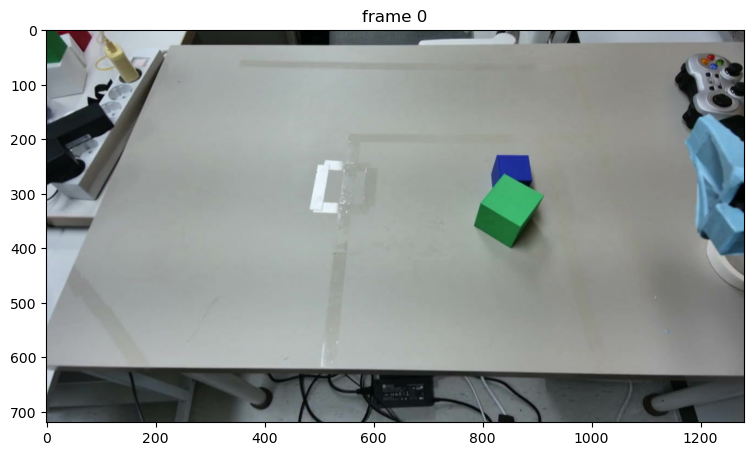

In [10]:
from pathlib import Path
import re
from PIL import Image
import matplotlib.pyplot as plt

data_set_root = "/home/nscl/diffusion_policy/data/please_please"  # 1셀과 동일하게
episode_id = 202  # 보고 싶은 에피소드 번호

ep_dir = Path(data_set_root) / "videos" / f"{episode_id:04d}"

# *_jpg 폴더 자동 탐색 (orbbec_jpg, d405_jpg 등)
jpg_dirs = [d for d in ep_dir.iterdir() if d.is_dir() and d.name.lower().endswith("_jpg")]
if not jpg_dirs:
    raise FileNotFoundError(f"'{ep_dir}' 안에 *_jpg 폴더가 없습니다. 먼저 ffmpeg로 JPG를 추출하세요.")

# 특정 카메라만 보고 싶으면 아래 한 줄로 선택:
# jpg_dir = next(d for d in jpg_dirs if d.name == "orbbec_jpg")
jpg_dir = jpg_dirs[0]
print(f"Using JPG dir: {jpg_dir}")

# 프레임 목록 수집 + 안전한 정렬(파일명 숫자 기준)
frame_paths = list(jpg_dir.glob("*.jpg"))
if not frame_paths:
    raise FileNotFoundError(f"{jpg_dir} 안에 .jpg 프레임이 없습니다.")



def numeric_key(p):
    m = re.search(r"\d+", p.stem)
    return int(m.group()) if m else float("inf")

frame_paths.sort(key=numeric_key)
N = len(frame_paths)
print(f"Found {N} frames")

# 인덱스 선택(범위 보정)
frame_idx = 0
if frame_idx >= N:
    print(f"[warn] frame_idx={frame_idx} > N-1={N-1}. 마지막 프레임으로 대체합니다.")
    frame_idx = N - 1

# 시각화
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(frame_paths[frame_idx]))
plt.axis("on")
plt.show()


#### Initialize the inference state

SAM 2는 대화형 비디오 분할을 위해 상태 기반 추론을 요구하므로 이 비디오에서 **추론 상태**를 초기화해야 합니다.

초기화 과정에서 `video_path`에 있는 모든 JPEG 프레임을 로드하고 `inference_state`에 해당 픽셀을 저장합니다(아래 진행률 표시줄 참조).

In [12]:
# print(jpg_dir)
inference_state = predictor.init_state(video_path=str(jpg_dir))     

frame loading (JPEG): 100%|██████████| 463/463 [00:06<00:00, 73.12it/s]


### Example 1: Segment & track one object

참고: 이 `inference_state`를 사용하여 이전에 추적을 실행한 적이 있다면, 먼저 `reset_state`를 통해 재설정하세요.

(아래 셀은 예시일 뿐입니다. 이 `inference_state`는 위에서 새로 초기화되었으므로 여기서는 `reset_state`를 호출할 필요가 없습니다.)

In [ ]:
import torch, gc

# 더 이상 안 쓸 때
del inference_state
# del predictor  # 모델까지 정리할 때만

gc.collect()
torch.cuda.empty_cache()
# 선택: IPC 핸들까지 정리
torch.cuda.ipc_collect()

print("allocated :", torch.cuda.memory_allocated()/1024**3, "GB")
print("reserved  :", torch.cuda.memory_reserved()/1024**3,  "GB")


allocated : 0.0 GB
reserved  : 0.0 GB


In [11]:

predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

시작하기 위해 왼쪽에 있는 자식을 분할해 보겠습니다.

여기서는 (x, y) = (210, 350) 지점에서 레이블 `1`을 사용하여 **양수 클릭**을 수행합니다. 이를 위해 자식의 좌표와 레이블을 `add_new_points_or_box` API로 전송합니다.

참고: 레이블 `1`은 *양수 클릭(영역 추가)*을 나타내고, 레이블 `0`은 *음수 클릭(영역 제거)*을 나타냅니다.

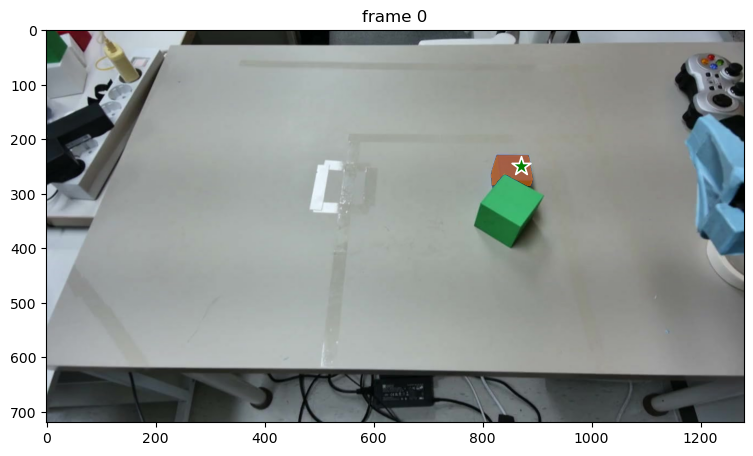

In [15]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (850, 370), (940,370) to get started
points = np.array([[870, 250]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(jpg_dir, frame_paths[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: Add a second click to refine the prediction

음, 왼쪽에 있는 아이를 분할하고 싶었지만, 모델은 반바지에 대한 마스크만 예측하는 것 같습니다. 한 번 클릭만으로는 대상 객체가 무엇인지 모호하기 때문에 이런 현상이 발생할 수 있습니다. 이 프레임에서 아이의 셔츠를 다시 한 번 긍정적으로 클릭하여 마스크를 세부적으로 조정할 수 있습니다.

여기서는 (x, y) = (250, 220) 지점에서 레이블이 `1`인 **두 번째 긍정적 클릭**을 수행하여 마스크를 확장합니다.

참고: `add_new_points_or_box`를 호출할 때는 **마지막 클릭뿐 아니라 **모든 클릭과 레이블**을 전송해야 합니다.

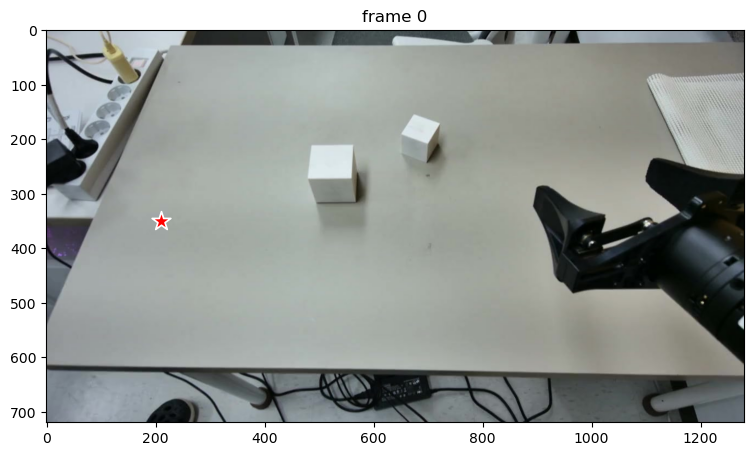

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0 ], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(jpg_dir, frame_paths[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

이 두 번째 세분화 클릭으로 이제 프레임 0의 전체 자식에 대한 분할 마스크를 얻게 됩니다.

#### 3단계: 비디오 전체에 마스크릿을 전달하기 위한 프롬프트 전파

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video: 100%|██████████| 463/463 [00:36<00:00, 12.84it/s]
OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


[OpenCV] Saved -> segmented_out_cv.mp4


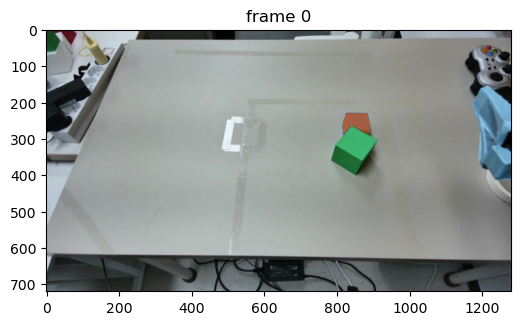

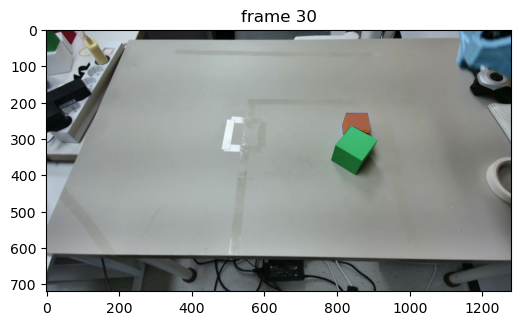

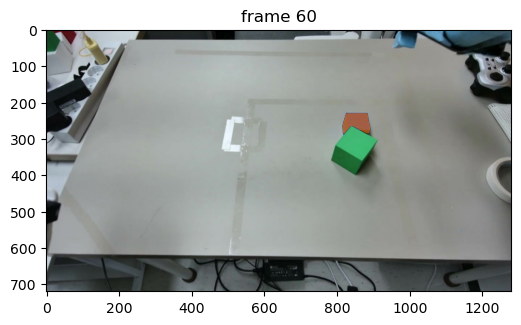

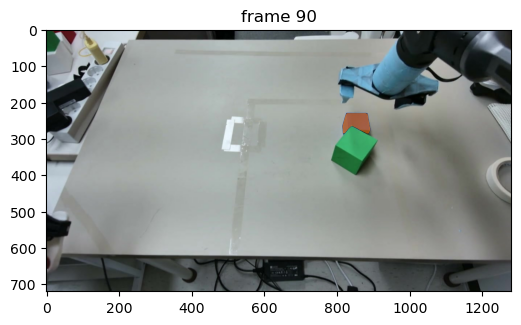

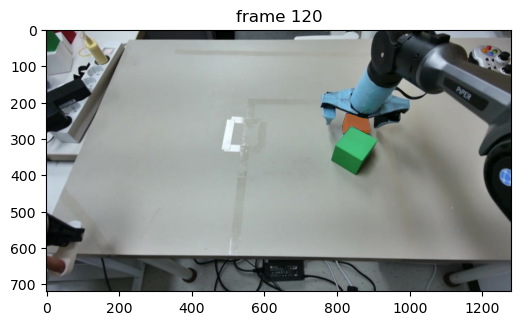

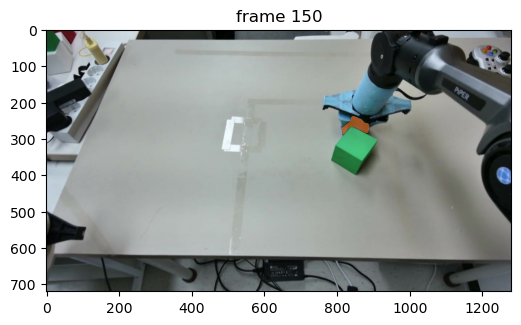

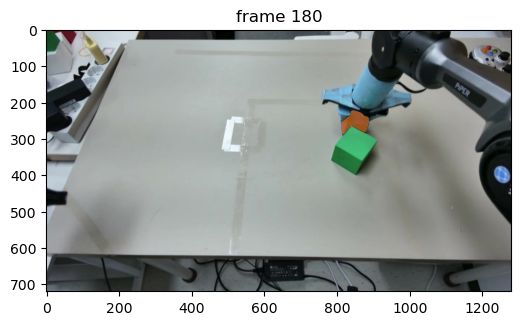

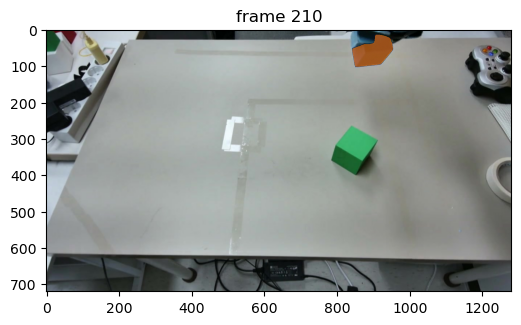

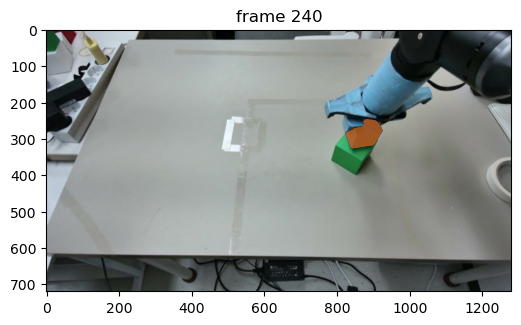

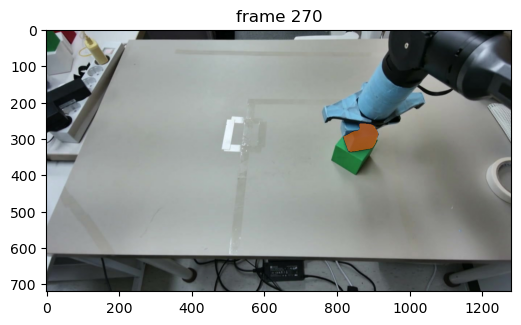

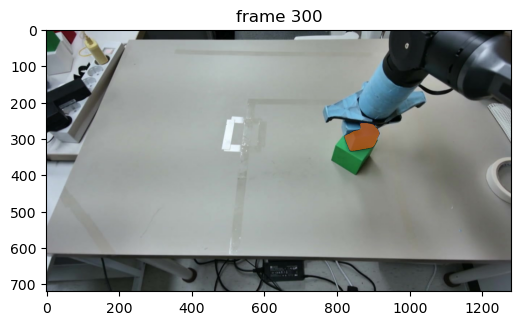

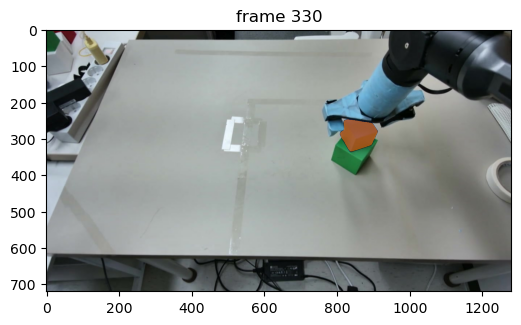

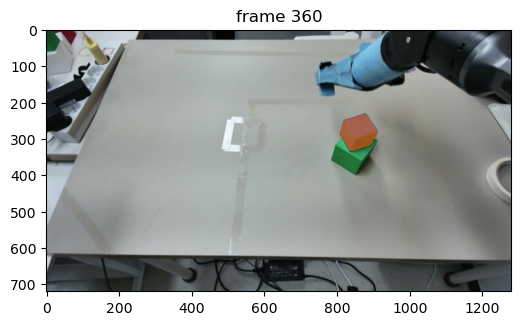

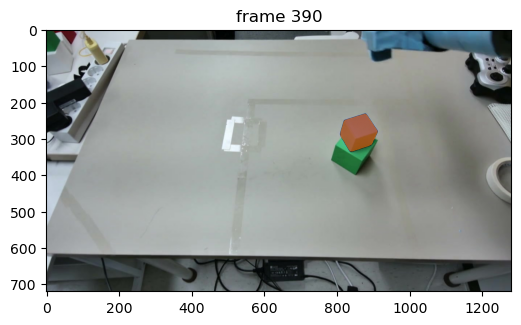

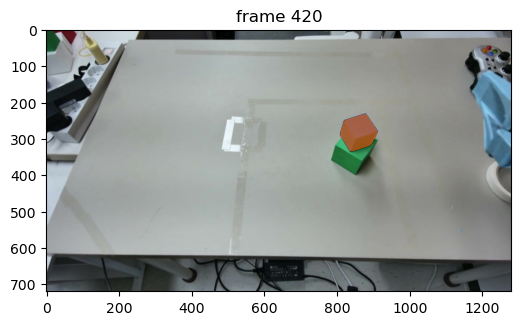

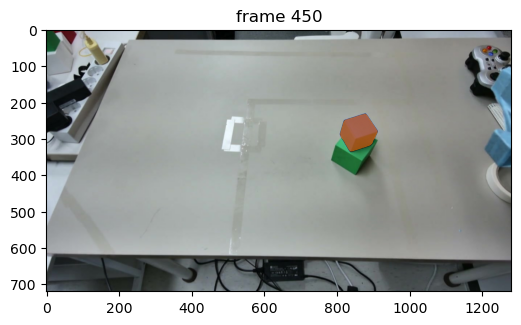

In [16]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_paths), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(jpg_dir, frame_paths[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

import os
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import zarr, numcodecs

def to_hw_bool_mask(mask: np.ndarray, H: int, W: int) -> np.ndarray:
    """mask을 (H,W) bool로 통일. (1,H,W) / (H,W,1) / (H,W) 모두 처리."""
    m = np.asarray(mask)
    # squeeze: (1,H,W) or (H,W,1) -> (H,W)
    if m.ndim == 3 and m.shape[0] == 1:     # (1,H,W)
        m = m[0]
    if m.ndim == 3 and m.shape[-1] == 1:    # (H,W,1)
        m = m[..., 0]
    # (H,W) 강제
    if m.ndim != 2:
        # 드물지만 (W,H)일 수 있으면 전치로 시도
        if m.shape == (W, H):
            m = m.T
        else:
            # 어쩔 수 없으면 평탄화 후 리사이즈
            m = m.astype(np.uint8)
            m = cv2.resize(m, (W, H), interpolation=cv2.INTER_NEAREST)
            return m.astype(bool)
    # 크기 다르면 리사이즈(Nearest)
    if m.shape != (H, W):
        m = cv2.resize(m.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
        return m.astype(bool)
    return m.astype(bool)




def save_segmentation_video_cv(
    jpg_dir,
    frame_paths,
    video_segments,
    out_path,
    fps=30,
    stride=1,
    alpha=0.5,
    draw_boundary=True,
    obj_ids=None,   # <- 새 파라미터: 로봇으로 집계할 obj_id 리스트 (None이면 모든 마스크 합집합)
    text_fmt="object_mask: {num}/{tot} ({pct:.2f}%)"  # 오버레이 문구 포맷
):
    """
    video_segments[out_frame_idx] = {obj_id: mask_bool(H,W), ...}
    stride: N이라면 N프레임마다 1장만 뽑아서 저장(=샘플링). fps도 함께 조정하거나 그대로 둘지 선택.

    obj_ids: 예) [1] 또는 [1, 3]. None이면 이 프레임의 모든 mask를 합집합으로 사용.
    """
    # 프레임 크기 확인
    first = np.array(Image.open(os.path.join(jpg_dir, frame_paths[0])).convert("RGB"))
    H, W = first.shape[:2]

    # mp4 인코더
    fourcc = cv2.VideoWriter_fourcc(*'H264')  # 환경에 따라 'mp4v'/'avc1'이 더 호환될 수 있음
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)

    eff_fps = fps if stride == 1 else max(1, fps // stride)
    writer = cv2.VideoWriter(out_path, fourcc, eff_fps, (W, H), True)

    # 색 팔레트
    palette = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255),
        (255, 255, 0), (255, 0, 255), (0, 255, 255),
        (255, 128, 0), (128, 0, 255), (0, 128, 255), (128, 255, 0)
    ]
    def color_of(obj_id):
        return palette[int(obj_id) % len(palette)]

    # 텍스트 그리기 유틸
    def draw_top_left_text(img, text, margin=6, font=cv2.FONT_HERSHEY_SIMPLEX, scale=0.6, thick=2):
        (tw, th), baseline = cv2.getTextSize(text, font, scale, thick)
        # 배경 박스
        x0, y0 = margin, margin
        x1, y1 = x0 + tw + 2*margin, y0 + th + baseline + 2*margin
        cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), -1)
        # 텍스트
        cv2.putText(img, text, (x0 + margin, y1 - baseline - margin), font, scale, (255, 255, 255), thick, cv2.LINE_AA)

    tot_pixels = H * W

    for i in range(0, len(frame_paths), stride):
        # 원본 프레임 (BGR)
        rgb = np.array(Image.open(os.path.join(jpg_dir, frame_paths[i])).convert("RGB"))
        bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
        out = bgr.copy()

        segs = video_segments.get(i, {})

        # --- 로봇 마스크 합성(합집합) ---
        object_union = np.zeros((H, W), dtype=bool)
        if obj_ids is None:
            # 모든 마스크를 합집합으로
            for _, mask in segs.items():
                m = to_hw_bool_mask(mask, H, W)
                object_union |= m
        else:
            # 지정한 obj_id만 합집합으로
            for oid in obj_ids:
                if oid in segs:
                    m = to_hw_bool_mask(segs[oid], H, W)
                    object_union |= m

        # --- 각 객체 시각화 ---
        for obj_id, mask in segs.items():
            m = to_hw_bool_mask(mask, H, W)
            if m.sum() == 0:
                continue
            color = np.array(color_of(obj_id), dtype=np.float32)

            # 알파블렌딩
            out[m] = ((1 - alpha) * out[m].astype(np.float32) + alpha * color).astype(np.uint8)

            if draw_boundary:
                cnts, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(out, cnts, -1, color_of(obj_id), thickness=2)

                # 라벨(centroid 근처)
                ys, xs = np.where(m)
                if xs.size > 0:
                    cx, cy = int(xs.mean()), int(ys.mean())
                    cv2.rectangle(out, (cx-12, cy-22), (cx+12, cy-4), (0,0,0), -1)
                    cv2.putText(out, str(obj_id), (cx-10, cy-8),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

        # --- 좌상단에 robot_mask 비율 표시 ---
        num_object = int(object_union.sum())
        pct = (num_object / tot_pixels * 100.0) if tot_pixels > 0 else 0.0
        text = text_fmt.format(num=num_object, tot=tot_pixels, pct=pct)
        draw_top_left_text(out, text)

        writer.write(out)

    writer.release()
    print(f"[OpenCV] Saved -> {out_path}")
    
save_segmentation_video_cv(
    jpg_dir, frame_paths, video_segments,
    out_path="segmented_out_cv.mp4", fps=30, stride=1, alpha=0.6,
    obj_ids=[1]
)




### zarr에 추가하기

In [39]:
###############################################################################
import zarr
import numpy as np
import cv2
import numcodecs
from pathlib import Path

def to_hw_bool_mask(mask: np.ndarray, H: int, W: int) -> np.ndarray:
    m = np.asarray(mask)
    if m.ndim == 3 and m.shape[0] == 1:     # (1,H,W)
        m = m[0]
    if m.ndim == 3 and m.shape[-1] == 1:    # (H,W,1)
        m = m[..., 0]
    if m.ndim != 2:
        # (W,H)일 수도 있으니 전치 시도, 실패하면 리사이즈
        if m.shape == (W, H):
            m = m.T
        else:
            m = cv2.resize(m.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
            return m.astype(bool)
    if m.shape != (H, W):
        m = cv2.resize(m.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
        return m.astype(bool)
    return m.astype(bool)

def compute_pct_from_segments(
    segments: dict,           # {frame_idx: {obj_id: mask_bool(H,W)}}
    H: int,
    W: int,
    num_frames: int,
    robot_obj_ids: list[int] | None = None  # None이면 해당 프레임의 모든 mask 합집합
) -> np.ndarray:
    """프레임별 로봇 마스크 비율[pct]을 길이 num_frames의 float32 배열로 반환."""
    tot = H * W
    pcts = np.zeros((num_frames,), dtype=np.float32)
    for fi in range(num_frames):
        mset = segments.get(fi, {})
        if not mset:
            continue
        union = np.zeros((H, W), dtype=bool)
        if robot_obj_ids is None:
            for _, m in mset.items():
                union |= to_hw_bool_mask(m, H, W)
        else:
            for rid in robot_obj_ids:
                if rid in mset:
                    union |= to_hw_bool_mask(mset[rid], H, W)
        pcts[fi] = (union.sum() / tot) if tot > 0 else 0.0
    return pcts

def write_occlusion_to_episode_zarr(
    episode_id: int,
    pcts: np.ndarray,
    recorder_root: str = "/home/nscl/diffusion_policy/data/last_dance/recorder_data",
    dataset_name: str = "occlusion",
    check_with_key: str = "pointcloud",   # 길이 정합 확인용 기준 키
    overwrite: bool = True
):
    ep_dir = Path(recorder_root) / f"episode_{episode_id:04d}"
    zarr_path = ep_dir / "obs_replay_buffer.zarr"
    if not zarr_path.exists():
        raise FileNotFoundError(f"Zarr not found: {zarr_path}")

    root = zarr.open(str(zarr_path), mode='a')
    g = root["data"]

    # Zarr 길이와 정합
    n_steps = int(g[check_with_key].shape[0]) if check_with_key in g else len(pcts)
    arr = np.asarray(pcts, dtype=np.float32)
    if len(arr) != n_steps:
        # 보수적으로 trim/pad
        print("mistach with point cloud len")
        out = np.zeros((n_steps,), dtype=np.float32)
        m = min(n_steps, len(arr))
        out[:m] = arr[:m]
        arr = out

    compressor = numcodecs.Blosc(cname='zstd', clevel=2, shuffle=numcodecs.Blosc.BITSHUFFLE)
    chunks = (min(2048, len(arr)),)
    g.create_dataset(dataset_name, data=arr, chunks=chunks, compressor=compressor, overwrite=overwrite)

    # 간단 메타데이터
    g[dataset_name].attrs.put({
        "desc": "Per-frame occlusion ratio (robot_mask / total_pixels) from SAM2",
        "source": "SAM2-propagate",
    })
    print(f"[OK] {dataset_name} saved to {zarr_path}/data ({len(arr)} steps)")


first_mask = next(iter(next(iter(video_segments.values())).values()))
H, W = np.asarray(first_mask).shape[-2:]
#    - Zarr 기준 길이 사용 권장 (비디오 프레임수와 1:1 대응)
zarr_root = str(data_set_root)+"/recorder_data"
zarr_path = f"{zarr_root}/episode_{episode_id:04d}/obs_replay_buffer.zarr"
g = zarr.open(zarr_path, mode='r')["data"]
num_frames = int(g["pointcloud"].shape[0])  # 네 파이프라인 표준
print(f"num_frames: {num_frames}")

# 1) pct 계산 (로봇 id를 특정하고 싶으면 robot_obj_ids=[...] 전달)
pcts = compute_pct_from_segments(
    segments=video_segments, H=H, W=W, num_frames=num_frames,
    robot_obj_ids=[1]  # None이면 프레임 내 모든 mask 합집합
)

# 2) Zarr에 'occlusion'으로 저장
write_occlusion_to_episode_zarr(
    episode_id=episode_id,
    pcts=pcts,
    recorder_root=zarr_root,
    dataset_name="occlusion"  # 요구하신 이름
)

num_frames: 831
[OK] occlusion saved to /home/nscl/diffusion_policy/data/last_dance/recorder_data/episode_0002/obs_replay_buffer.zarr/data (831 steps)
